<a href="https://colab.research.google.com/github/nhurleywalker/2018-03-20-SciTech-Data/blob/master/ULPT_simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy.stats import loguniform

In [2]:
# To unwrap longitudes
def unwrap(x):
    if x > 180.:
        xr = x - 360
    else:
        xr = x
    return xr
vunwrap = np.vectorize(unwrap, otypes=[float])

In [3]:
def P_sensitivity(P, sample_time=4, dwell_time=60 * 60, int_time = 100 * 60 * 60, pulse_occupancy=0.05):
    ''' sensitivity function to objects with different periods
    as a function of sample time, dwell time, and total integration time '''
    width = P * pulse_occupancy
    N = int_time / dwell_time
#    print(f"period {P}, integration time {int_time}, dwell {dwell_time}, N {N}")
    if width < sample_time:
        return 0
    else:
        if P < 5 * sample_time:
            return 0 
        elif P > 5 * sample_time and P < 20 * sample_time: 
            m = 1 / (20 * sample_time - 5 * sample_time) 
            b = 1 - (20 / (20 - 5)) 
            return m * P + b 
        elif P > 20 * sample_time and P < dwell_time: 
            return 1 
        elif P > dwell_time: 
    # It is a dice roll whether you happen to sample the pulse phase when you return to this pointing.
    # The number of dice rolls N you make is the total integration time / dwell time
    # The chance of NOT detecting the source in ANY of those N dice rolls is (1 - dwell/P)^N
    # And we want the probability that we detected the source in ANY of the epochs
#            print(1 - (1 - dwell_time / P)**N)
            return 1 - ((1 - (dwell_time / P))**N)
vP_sensitivity = np.vectorize(P_sensitivity, otypes=[float])


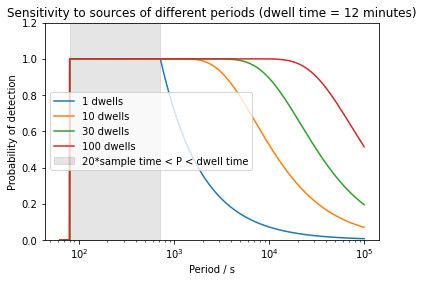

In [4]:
# Demonstration of the P_sensitivity function
Prange = np.logspace(1.8, 5, num=10000, base=10)
fig = plt.figure()
ax = fig.add_subplot(111)
ndwells = [1, 10, 30, 100]
for n in ndwells:
    ax.plot(Prange, vP_sensitivity(Prange, sample_time=4, dwell_time=12*60, int_time=n*12*60), label=f"{n} dwells")
miny, maxy = 0.0, 1.2
ax.fill_betweenx(np.linspace(miny, maxy, 2), 20*4, 12*60, alpha=0.1, color="k", label="20*sample time < P < dwell time")
ax.set_ylim([miny, maxy])
ax.set_xscale("log")
ax.set_xlabel("Period / s")
ax.set_ylabel("Probability of detection")
ax.set_title("Sensitivity to sources of different periods (dwell time = 12 minutes)")
ax.legend()
fig.show()

In [5]:
def flux_sensitivity(P, peak, sample_rms, sample_time, pulse_occupancy=0.05):
    ''' sensitivity function to pulses with different flux densities:
    P * pulse_occupancy = pulse_width
    pulse width * 0.5 * peak = approximation to the fluence, in Jys
    signal to noise = fluence / (RMS noise of a sample, and width of the sample in s) '''
    SNR = P * pulse_occupancy * peak * 0.5 / (sample_rms * sample_time)
    if SNR > 7:
        return 1
    else:
        return 0
vflux_sensitivity = np.vectorize(flux_sensitivity, otypes=[float])

<bound method Figure.show of <Figure size 432x288 with 1 Axes>>

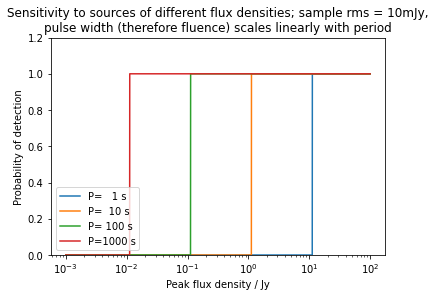

In [7]:
# Demonstration of the flux_sensitivity function
srange = np.logspace(-3, 2., num=10000, base=10)
Prange = [1, 10, 100, 1000]
fig = plt.figure()
ax = fig.add_subplot(111)
for P in Prange:
    ax.plot(srange, vflux_sensitivity(P, srange, sample_rms=0.01, sample_time=4), label=f"P={P:4.0f} s")
miny, maxy = 0.0, 1.2
#ax.fill_betweenx(np.linspace(miny, maxy, 2), 20*4, 12*60, alpha=0.1, color="k", label="20*sample time < P < dwell time")
ax.set_ylim([miny, maxy])
ax.set_xscale("log")
ax.set_xlabel("Peak flux density / Jy")
ax.set_ylabel("Probability of detection")
ax.set_title("Sensitivity to sources of different flux densities; sample rms = 10mJy,\npulse width (therefore fluence) scales linearly with period")
ax.legend()
fig.show()

In [8]:
def scatter_sensitivity(P, t_scat, dwell_time = 12 * 60, pulse_occupancy=0.05):
    ''' sensitivity function as pulse widths approach the scattering timescale '''
    width = P * pulse_occupancy
    # Once a pulse is wide enough that it meets the scattering timescale, that's now the timescale we care about
    tau = np.maximum(width, t_scat)
    # If the pulse occupies less than a quarter of the observation, a matched filter should retrieve it
    if tau < 0.25 * dwell_time:
        return 1
    # If the apparent pulse width starts to approach the dwell_time, we will be decreasingly likely to detect it
    elif tau > 0.25 * dwell_time and tau < 0.5*dwell_time:
        return (1 / ((0.25 - 0.5)*dwell_time))*tau + 2
    # If the pulse is wider than half the dwell time, we won't detect it
    elif tau > 0.5 * dwell_time:
        return 0
vscatter_sensitivity = np.vectorize(scatter_sensitivity, otypes=[float])

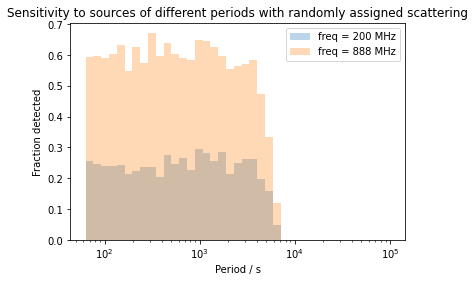

In [10]:
# Demonstration of the scatter_sensitivity function
Prange = np.logspace(1.8, 5, num=10000, base=10)
# Generate a range of random scattering parameters
tsrange = loguniform.rvs(1.e-2, 1.e5, size=len(Prange))

fig = plt.figure()
ax = fig.add_subplot(111)
freqs = [0.2, 0.888]
bins = np.logspace(start=np.log10(np.min(Prange)), stop=np.log10(np.max(Prange)), num=40)
count, bins = np.histogram(Prange, bins=bins)
center = (bins[:-1] + bins[1:]) / 2
width = bins[1:] - bins[:-1]
for nu in freqs:
    t_scat = tsrange*(nu)**-3.86
    count_survey, _ = np.histogram(Prange, weights = vscatter_sensitivity(Prange, t_scat), bins = bins)
    ax.bar(center, count_survey/count, align='center', width=width, alpha=0.3, label=f"freq = {nu*1.e3:3.0f} MHz")
ax.set_xscale("log")
ax.set_xlabel("Period / s")
ax.set_ylabel("Fraction detected")
ax.set_title("Sensitivity to sources of different periods with randomly assigned scattering")
ax.legend()
fig.show()

In [11]:
def spatial_sensitivity(l, b, survey='vast'):
    ''' sensitivity function of the surveys to different Galactic coordinates '''
    if survey == 'vast':
        if np.abs(b) < 7:
            if l < 25 and l > (225 - 360):
                return 1
            else:
                return 0
        else:
            return 0
        # MWA archive covers the whole southern sky already
    elif survey == 'mwa':
        return 1
vspatial_sensitivity = np.vectorize(spatial_sensitivity)

In [12]:
def duty_sensitivity(N, archive_depth=10, activity_window=1, normalisation=10):
    ''' sensitivity function to objects with different activity windows;
#    we assume sources are on for one year and normalise the chance to 100% for 10 years
#    so the simulation doesn't have to be too large'''
    return (archive_depth * activity_window / normalisation) * np.ones(len(N))


In [13]:
def S(S0, nu0, nu, alpha=-3.17, beta=-0.56): 
    ''' get flux density of source at a given frequency;
        based on real spectrum of GPMJ1839-10 '''
    return S0 * (nu/nu0) ** (alpha * np.exp(beta * np.log(nu/nu0) ** 2)) 


In [24]:
# Load the data
# Generated from PsrPopPy using
# pop = populate.generate(1.e6,
#                            electronModel='ne2001',
#                            radialDistType='lfl06',
#                            nostdout=True # switches off output to stdout
#                           )
# Could not be included in this notebook as PsrPopPy won't install to Colab

if not os.path.exists(popsub):
    !wget https://www.dropbox.com/s/qdoyvtln0ay9tbs/large_population_sub.csv?dl=0 -O large_population_sub.csv
print(f"Reading population from {popsub}")
pop = pd.read_csv(popsub)
l = pop["l"].to_numpy()
b = pop["b"].to_numpy()
x = pop["x"].to_numpy()
y = pop["y"].to_numpy()
z = pop["z"].to_numpy()
dm = pop["dm"].to_numpy()
t_scat = pop["t_scat"].to_numpy()

--2023-02-15 06:34:24--  https://www.dropbox.com/s/qdoyvtln0ay9tbs/large_population_sub.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/qdoyvtln0ay9tbs/large_population_sub.csv [following]
--2023-02-15 06:34:25--  https://www.dropbox.com/s/raw/qdoyvtln0ay9tbs/large_population_sub.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucde9a75ab685462385217b57e9b.dl.dropboxusercontent.com/cd/0/inline/B2j7LpJ1rDWyBflUO6O0B1FzeFp37PLukK-hTerCra4SYncLKZf99FYUyyIkAmgp4wKuPt_D8Ns1ZYjzChgumcj0Tn05kYcvhKq1dfdu2S7DR833whLRj98_z0l6UoxhtURCTnHUhKr3rS-V6iUbOZQH8ldaeu9UNmAELnWKHM4Zfg/file# [following]
--2023-02-15 06:34:25--  https://ucde9a75ab685462385217b57e9b.dl.dropboxusercontent.com/cd/0/inline/B2j7LpJ1rDWyBflUO6O0B1FzeFp37PLukK-hTer

In [25]:
# Derived quantity
dist = np.sqrt((x - 0)**2 + (y - 8)**2 + (z - 0)**2)

In [26]:
# Pulsar period distribution: log uniform between 1 minute and 8 hours
# In practice all sensitivity falls off > 1.e4 seconds
Pmax = 1.e4 # seconds
Pmin = 60 # seconds
#P = np.random.rand(len(pop.population)) * (Pmax  - Pmin) + Pmin
P = loguniform.rvs(Pmin, Pmax, size=len(l))

In [27]:
# Single-pulse luminosity distribution flat and equal to that of GPMJ1839-10 or GLXJ1627
# We want 40 Jy at 150 MHz at 1.2 kpc
# Pseudo-luminosity = 40 * 1.2 * 1.2 Jy kpc^2
lum_150 = 40 * 1.2 * 1.2 * np.ones(len(l))
# Scale to 1GHz
lum = S(lum_150, 0.15, 1.0)

In [28]:
# Single pulse flux density distribution = new luminosity /r^2
s = lum / (dist ** 2)


Text(0, 0.5, 'Y')

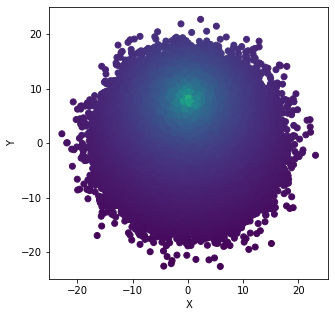

In [29]:
# Sanity check that sources get fainter with distance in the way you'd expect
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)                                 
ax.scatter(x, y, c = np.log10(s))
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()

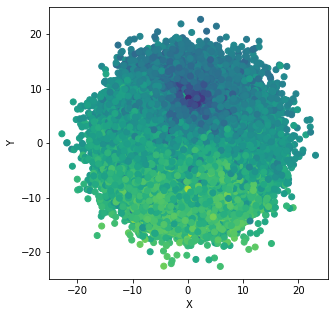

In [30]:
# Sanity check that scattering increases with distance in the way you'd expect
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)                                 
ax.scatter(x, y, c = np.log10(t_scat))
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()

In [31]:
# Survey-dependent parameters
# VAST
vast_sample_rms = 0.004 # Jy/beam as derived from real VAST Galactic plane data
vast_sample_time = 10 # seconds
vast_dwell_time = 12 * 60 # seconds
vast_archive_depth = 2 # years, by end of 2024
vast_int_time = 96 * vast_dwell_time / vast_archive_depth # 96 integrations per 12-minute pointing, split over the years
vast_nu = 0.888 # GHz
vast_t_scat = t_scat*(vast_nu)**-3.86
vast_s = S(s, 1, vast_nu)

# MWA
mwa_sample_rms = 0.1 # Jy/beam as derived from real MWA Galactic plane data
mwa_sample_time = 4 # seconds
mwa_dwell_time = 60 * 60 # seconds (typical of archival observations)
mwa_archive_depth = 10 # years
mwa_int_time = 100 * 60 * 60 / mwa_archive_depth + (30 * 60 * 60 / 3) # Approx 100 hours per pointing on the Galaxy in the archive -- split over the years, plus 30 hours per pointing for each of the three epochs of the GPM
mwa_nu = 0.2 # GHz
mwa_t_scat = t_scat*(mwa_nu)**-3.86
mwa_s = S(s, 1, mwa_nu)

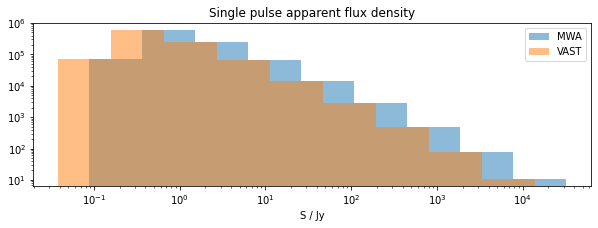

In [32]:
# Check flux density distribution for sanity
fig = plt.figure(figsize=(10, 3))                         
ax = fig.add_subplot(111)                                 
ax.hist(mwa_s, log = 'true', bins=np.logspace(start=np.log10(np.min(mwa_s)), stop=np.log10(np.max(mwa_s)), num=10), label="MWA", alpha=0.5)
ax.hist(vast_s, log = 'true', bins=np.logspace(start=np.log10(np.min(vast_s)), stop=np.log10(np.max(vast_s)), num=10), label="VAST", alpha=0.5)
ax.set_title("Single pulse apparent flux density")
ax.legend()
ax.set_xlabel("S / Jy")
ax.set_xscale('log')
plt.show()

In [33]:
# Apply each sensitivity filter to the population
vast_probability = vP_sensitivity(P, sample_time = vast_sample_time, dwell_time = vast_dwell_time, int_time = vast_int_time) * \
                   vscatter_sensitivity(P, vast_t_scat, vast_dwell_time) * \
                   vflux_sensitivity(P, vast_s, vast_sample_rms, vast_sample_time) * \
                   vspatial_sensitivity(l, b, 'vast') * \
                   duty_sensitivity(P, vast_archive_depth) 

# Note that we use 5 minutes for MWA dwell time for the scattering (i.e. matched filter)
# calculation, since diffuse emission in the Galactic plane makes the flux density wander
# We can use the full dwell time for the period, though
mwa_probability = vP_sensitivity(P, sample_time = mwa_sample_time, dwell_time = mwa_dwell_time, int_time = mwa_int_time) * \
                   vscatter_sensitivity(P, mwa_t_scat, 5*60) * \
                   vflux_sensitivity(P, mwa_s, mwa_sample_rms, mwa_sample_time) * \
                   vspatial_sensitivity(l, b, 'mwa') * \
                   duty_sensitivity(P, mwa_archive_depth) 


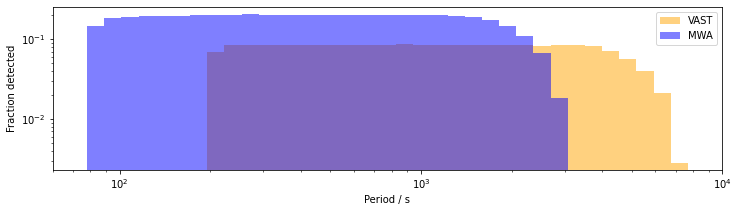

In [40]:
# Final plot showing detection rates for the different surveys
fig = plt.figure(figsize=(12,3))                         
ax = fig.add_subplot(111)                                 
kwargs = { 'alpha' : 0.5 }

bins = np.logspace(start=np.log10(np.min(P)), stop=np.log10(np.max(P)), num=40)
# How many are in the simulations
count, bins = np.histogram(P, bins=bins)
center = (bins[:-1] + bins[1:]) / 2
width = bins[1:] - bins[:-1]
# How many are detected by the different surveys
count_vast, _ = np.histogram(P, weights = vast_probability, bins=bins) 
count_mwa, _ = np.histogram(P, weights = mwa_probability, bins=bins) 
# Plot detection fractions
ax.bar(center, count_vast/count, align='center', width=width, color='orange', label=f"VAST", **kwargs)
ax.bar(center, count_mwa/count, align='center', width=width, color='blue', label=f"MWA", **kwargs)
ax.set_xlim(Pmin, Pmax)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc=1)
ax.set_ylabel("Fraction detected")
ax.set_xlabel("Period / s")
plt.show()